### DFRでの飛行シミュレーションに相当するトイモデル

#### 前提
- 周期境界

#### ルール
- 前の空いてるマスと同じだけ進む（MAX=2）.
- パラレルアップデート
- 参照可能な場合は、前の車の速度を参照しそれを元に自分の速度を決定して良い（`Policy = "dfr"`）.
  

In [187]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd



In [180]:
class Car:
    def __init__(self, idx, position):
        self.id = idx
        self.position = position
        self.speed_log = [0]
        self.position_log = [position]
        self.is_active = True
        self.speed = 0

    def decide_speed(self, leader, noise_ratio, total_cell, policy="simple"):
        """
        十分に車間距離が空いている場合は速度2
        """
        # 自分が先頭の場合たまにノイズ
        if (leader.position - self.position)<0 and random.random() < noise_ratio:
            self.speed = 0
            return
        
        if (leader.position - self.position) % total_cell  >= 3:
            self.speed = 2
            return
        """
        それ以外の場合はPolicyに応じて前の車の速度を用いた速度決定. 
        """
        # DFRの場合
        if policy == "dfr":
            if(leader.position - self.position) % total_cell >= 2:
                self.speed = leader.speed
                return
            self.speed = leader.speed
            return
        
        # ここは普通のASEPの進み方
        if (leader.position - self.position) % total_cell >= 2:
            self.speed = 1
            return 
        else:
            self.speed = 0
            return 
        return

    def move(self, total_cell):
        self.position += self.speed
        if self.position >= total_cell:
            self.position -= total_cell
        self.position_log.append(self.position)
        self.speed_log.append(self.speed)

class DFRSimulation:

    def __init__(self, **kwargs):
        self.update_rule = kwargs.get("update_rule", "parallel")
        self.initial_position = kwargs.get("INITIAL_POSITION",[])
        self.cars = [Car(idx=idx, position=position) for idx, position in enumerate(self.initial_position)]
        self.TOTAL_CELL = kwargs.get("TOTAL_CELL",40)
        self.TIME_STEPS = kwargs.get("TIME_STEPS",1000)
        self.NOISE_RATIO = kwargs.get("NOISE_RATIO",0.1)
        self.POLICY = kwargs.get("POLICY","simple")
        self.MEAN_SPEED_LOG = []

    def step_periodic(self):
        """
        εの影響を考慮しない、ただの初等的なASEP.
        """
    
        if self.update_rule == "parallel":
            for idx, car in enumerate(self.cars):
                leader = self.cars[int(idx-1)]
                car.decide_speed(leader=leader, noise_ratio=self.NOISE_RATIO, policy=self.POLICY, total_cell=self.TOTAL_CELL)
            for car in self.cars:
                car.move(total_cell=self.TOTAL_CELL)

        if self.update_rule == "sequential":
            for car in self.cars:
                car.decide_speed()
                car.move(self.TOTAL_CELL)

    def save_by_step(self):
        active_cars = [car for car in self.cars if car.is_active]
        mean_speed = np.mean([car.speed for car in active_cars])
        self.MEAN_SPEED_LOG.append(mean_speed)  
            
    def simulate(self):
        for time in range(self.TIME_STEPS):
            # if time%20 == 0:
            #     print("t=",time)
            self.step_periodic()
            self.save_by_step()

    def output_results(self, threshold=0.7):
        # まずは平均速度の計算. 
        threshold_time = int(self.TIME_STEPS * threshold)
        mean_speed = np.mean(self.MEAN_SPEED_LOG[threshold_time:])
        current = mean_speed * len(self.cars)
        return {"mean_speed":mean_speed, "current":current}

    def create_video(self, filename='simulation.gif'):
        fig, ax = plt.subplots(figsize=(6, 6))

        # 円形にプロットするための設定
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal', 'box')

        colors = ['black'] * (len(self.cars) -1)
        colors.append("red")
        
        # プロットの初期化
        scatters = [ax.plot([], [], 'o', color=colors[i % len(self.cars)])[0] for i in range(len(self.cars))]
        
        def init():
            for scatter in scatters:
                scatter.set_data([], [])
            return scatters

        def update(frame):
            for i, car in enumerate(self.cars):
                # 各車の位置を角度に変換
                theta = 2 * np.pi * car.position_log[frame] / self.TOTAL_CELL
                x = [np.cos(theta)]
                y = [np.sin(theta)]

                scatters[i].set_data(x, y)
            return scatters

        # アニメーションの作成
        anim = FuncAnimation(fig, update, frames=self.TIME_STEPS, init_func=init, blit=True)
        anim.save(filename, writer='pillow')

        
    


In [188]:
CELL_NUM = 200
GLOBAL_DENSITY = 0.5
NUM_CARS = int(CELL_NUM * GLOBAL_DENSITY)
INITIAL_POSITION = sorted(random.sample(range(CELL_NUM), NUM_CARS), reverse=True)
NOISE_RATIO = 0.15

In [189]:
args = {"update_rule":"parallel", "INITIAL_POSITION":INITIAL_POSITION, "TIME_STEPS":200, "TOTAL_CELL":CELL_NUM, \
       "NOISE_RATIO":NOISE_RATIO}

# 新しいキーと値を追加
args_dfr = {**args, "POLICY": "dfr"}

simulationObj = DFRSimulation(**args)
simulationObj_dfr = DFRSimulation(**args_dfr)


In [190]:
simulationObj.simulate()
simulationObj_dfr.simulate()

In [177]:
print("====SIMPLE=====")
# print(len(simulationObj.cars))
print(simulationObj.output_results())
print()
print("====DFR=====")
# print(len(simulationObj_dfr.cars))
print(simulationObj_dfr.output_results())

====SIMPLE=====
{'mean_speed': 0.9871666666666667, 'current': 98.71666666666667}

====DFR=====
{'mean_speed': 1.9636666666666664, 'current': 196.36666666666665}


In [193]:
### ここからシミュレーション開始 ###

global_densities = [(i+1) / 10 for i in range(10)]
NOISE_LIST = [(i) / 20 for i in range(5)]

result_simple = []
result_dfr = []
for noise in NOISE_LIST:
    print(noise)
    for density in global_densities:
        NUM_CARS = int(CELL_NUM * density)
        INITIAL_POSITION = sorted(random.sample(range(CELL_NUM), NUM_CARS), reverse=True)
        args = {"update_rule":"parallel", "INITIAL_POSITION":INITIAL_POSITION, "TIME_STEPS":200, "TOTAL_CELL":CELL_NUM, \
           "NOISE_RATIO":noise}
        args_dfr = {**args, "POLICY": "dfr"}
        simulationObj = DFRSimulation(**args)
        simulationObj_dfr = DFRSimulation(**args_dfr)
    
        # シミュレーション実行
        simulationObj.simulate()
        simulationObj_dfr.simulate()
    
        # 結果の保存
        result_simple.append({**simulationObj.output_results(), "density":density, "noise":noise})
        result_dfr.append({**simulationObj_dfr.output_results(), "density":density, "noise":noise})

    
    

0.0
0.05
0.1
0.15
0.2


In [196]:
df = pd.DataFrame(result_dfr)
# print(result_dfr)
df.head()

,mean_speed,current,density,noise
0,2.0,40.0,0.1,0.0
1,2.0,80.0,0.2,0.0
2,2.0,120.0,0.3,0.0
3,2.0,160.0,0.4,0.0
4,2.0,200.0,0.5,0.0


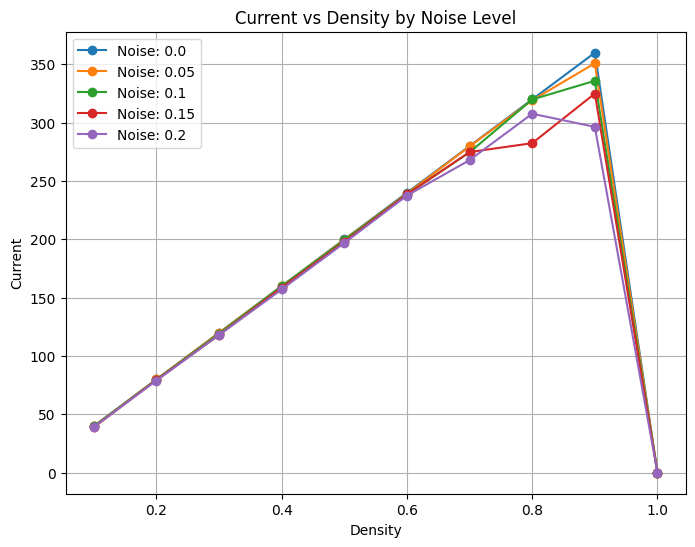

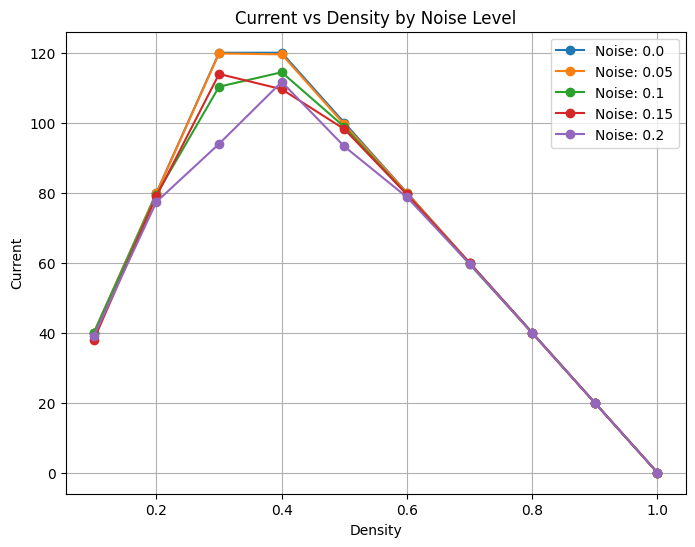

In [202]:
def plot(data):
    new_df = pd.DataFrame(data)

    # プロットの作成
    plt.figure(figsize=(8, 6))
    
    # ノイズレベルごとに異なる色でプロット
    for noise_level in new_df['noise'].unique():
        subset = new_df[new_df['noise'] == noise_level]
        plt.plot(subset['density'], subset['current'], marker='o', label=f'Noise: {noise_level}')
    
    # 軸ラベルの設定
    plt.xlabel('Density')
    plt.ylabel('Current')
    
    # グラフのタイトル
    plt.title('Current vs Density by Noise Level')
    
    # 凡例の追加
    plt.legend()
    plt.grid()
    
    # グラフの表示
    plt.show()

plot(result_dfr)
plot(result_simple)

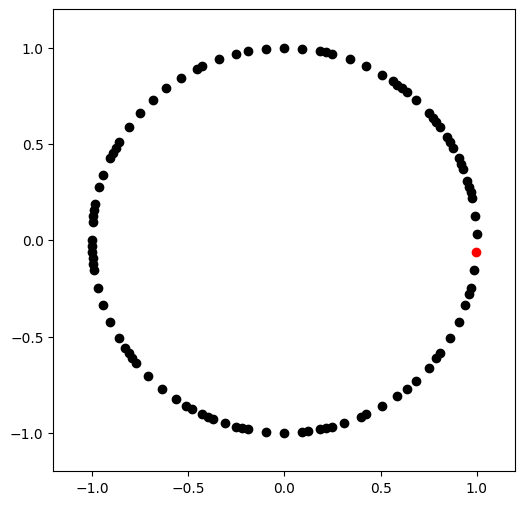

In [156]:
simulationObj.create_video()

In [139]:
["black"] * 10

['black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'black']